In [1]:
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
from tensorflow import keras
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

#numpy配列を省略しないようにする
np.set_printoptions(threshold=np.inf)
#pandasを省略しないようにする
pd.set_option('display.max_columns', 500) # 列
pd.set_option('display.max_rows', 500)  # 行

mm = preprocessing.MinMaxScaler()  # 正規化エンコード、デコード

In [2]:
# 正規化関数
def mmscaler(data):
    mm = preprocessing.MinMaxScaler()  # 正規化エンコード、デコード
    dat = mm.fit_transform(data)
    return dat

# 目的変数の作成関数 1:df 2:目的変数のカラム名称 3:shiftさせるカラム名称 4:shiftする数
def shift(df, t_name, t_column, shift):
    df[t_name] = df[t_column].shift(shift) # 1行上にずらして5分後の値にしている
    return df

# トレーニングデータの作成
def create_data(read_dir, save_dir):
    df = pd.read_csv(read_dir, encoding='shift_jis')
    #カラムを削除
    df = df.dropna()  # NaNを削除
    #df.drop(labels='日付(ローソク足)', axis=1, inplace=True) # ろうそく足データの日付
    
    df['time'] = pd.to_datetime(df['time']  )#, format='%Y-%m-%d-%A %H:%M:%S')  # 日付カラムを日付型に変換
    df['time(hour)'] = df['time'].dt.hour  # hourをデータに追加
    df['time(minute)'] = df['time'].dt.minute  # minuteをデータに追加
    df['time(weekday)'] = df['time'].dt.dayofweek  # minuteをデータに追加
    # df['日付']カラムが [datetime64[ns]]型になっていて扱いづらいので最後に削除する
    #df.drop(labels='日付', axis=1, inplace=True)
    
    date = df['time'] # 代入して変数を避難させる
    
    
    shift(df, 'y_rate_1h', 'close', -1)  # 目的変数の作成関数
    shift(df, 'y_rate_2h', 'close', -2)  # 目的変数の作成関数
    shift(df, 'y_rate_3h', 'close', -3)  # 目的変数の作成関数
    shift(df, 'y_rate_4h', 'close', -4)  # 目的変数の作成関数
    shift(df, 'y_rate_5h', 'close', -5)  # 目的変数の作成関数
    shift(df, 'y_rate_6h', 'close', -6)  # 目的変数の作成関数
    shift(df, 'y_rate_7h', 'close', -7)  # 目的変数の作成関数
    shift(df, 'y_rate_8h', 'close', -8)  # 目的変数の作成関数
    shift(df, 'y_rate_9h', 'close', -9)  # 目的変数の作成関数
    shift(df, 'y_rate_10h', 'close', -10)  # 目的変数の作成関数
    shift(df, 'y_rate_11h', 'close', -11)  # 目的変数の作成関数
    shift(df, 'y_rate_12h', 'close', -12)  # 目的変数の作成関数
    shift(df, 'y_rate_13h', 'close', -13)  # 目的変数の作成関数
    shift(df, 'y_rate_14h', 'close', -14)  # 目的変数の作成関数
    shift(df, 'y_rate_15h', 'close', -15)  # 目的変数の作成関数
    shift(df, 'y_rate_16h', 'close', -16)  # 目的変数の作成関数
    shift(df, 'y_rate_17h', 'close', -17)  # 目的変数の作成関数
    shift(df, 'y_rate_18h', 'close', -18)  # 目的変数の作成関数
    shift(df, 'y_rate_19h', 'close', -19)  # 目的変数の作成関数
    shift(df, 'y_rate_20h', 'close', -20)  # 目的変数の作成関数
    shift(df, 'y_rate_21h', 'close', -21)  # 目的変数の作成関数
    shift(df, 'y_rate_22h', 'close', -22)  # 目的変数の作成関数
    shift(df, 'y_rate_23h', 'close', -23)  # 目的変数の作成関数
    shift(df, 'y_rate_24h', 'close', -24)  # 目的変数の作成関数

    
    df = df.dropna()  # NaNを削除
    #df = df.loc[:, '2':'time(weekday)'].astype('float32')  # データ型をfloatに変換して代入
    #df.insert(0, 'time(week)', date)  # 日付を1列目に代入
    #df.to_csv(save_dir , encoding='shift_jis', index=False)
    return df

# 入力したインプットデータを正規化、形状を整える関数
def create_traindata(df, X_train, y_train):

    print('入力数:', X_train.columns)
    row_count = len(y_train)  # 行数を取得(形状の作成に使用)
    column_count = len(X_train.columns)  # 列数を取得(形状の作成に使用)
    
    print('行数:', row_count)
    print('列数:', column_count)
    print('整形前の形状(特徴量):', X_train.shape)
    X_train = mm.fit_transform(X_train)  # 正規化
    pickle.dump(mm, open('./dump/X_train_scaler.sav', 'wb'))
    X_train = np.array(X_train).reshape(row_count, column_count, -1)  # 特徴量の形状(3次元)
    y_train = np.array(y_train).reshape(row_count,1)  # 特徴量の形状
    y_train = mm.fit_transform(y_train)  # 正規化
    pickle.dump(mm, open('./dump/y_train_scaler.sav', 'wb'))

    print('形状(特徴量):', X_train.shape)
    print('形状(目的変数):', y_train.shape)
    return X_train, y_train


# 予測関数
def predict(model, X_train, y_train):
    y_pred_one = model(X_train[-2:-1])  # 最終行の予測
    y_pred = model(X_train)
    y_pred_one = mm.inverse_transform(y_pred_one)  # 予測結果の正規化をデコード
    y_pred = mm.inverse_transform(y_pred)  # 予測結果の正規化をデコード
    y_train = mm.inverse_transform(y_train)  # 実際の結果の正規化をデコード
    return y_pred_one, y_pred, y_train

# プロット関数
def plot_result(y_pred, y_train, title):
    flg = plt.figure()
    fig = plt.figure(figsize=(6, 4), dpi=72, linewidth=10)
    ax = fig.add_subplot(111, xlabel='number', ylabel='price',title=title)  # グラフ作成
    
    ax.plot(y_train, label='actual')  # 実測
    ax.plot(y_pred, label='predict')  # 予測
    
    plt.legend()
    
# 学習関数
def learn(df, X_train, y_rate, title, epochs, model_dir, param_dir):
    #**********1時間後予測**********学習のinput情報(特徴量、答え)
    y_train = df.loc[:, y_rate]  # 全行 , 最終列
    X_train, y_train = create_traindata(df, X_train, y_train)  # 入力したインプットデータをdropna、正規化、形状を整える
    model = learn_model(X_train, y_train, model_dir, param_dir, epochs)  # モデルの学習
    y_pred_one, y_pred, y_train = predict(model, X_train, y_train) # 予測
    #y_train = df.loc[:, y_rate]  # y_trainを代入しなおす
    plot_result(y_pred, y_train, title)  # プロット
   # y_pred = model(X_train.iloc[-1])
    return y_pred_one, y_pred

In [3]:
# モデル作成関数
def model_create():
    #n_inputs = len(X_train.columns)  # 入力数
    model = keras.models.Sequential()
   # model.add(keras.layers.Dense(1200, activation='sigmoid'))
   # model.add(keras.layers.Dense(12, activation='linear'))
   # model.add(keras.layers.Dense(6, activation='linear'))
    model.add(keras.layers.LSTM(1, activation='linear',
                  #recurrent_activation='sigmoid',
                  kernel_initializer='glorot_normal',
                   recurrent_initializer='orthogonal',
                               batch_input_shape=(None, n_inputs, 1)))
    #model.add(keras.layers.Dense(1200, activation='linear'))
    #model.add(keras.layers.Dense(100, activation='linear'))
    #model.add(keras.layers.Dense(50, activation='linear'))
    #model.add(keras.layers.Dense(7, activation='linear'))
    #model.add(keras.layers.Dense(1, activation='linear'))
    
    optimizer = keras.optimizers.Adam(lr=0.1)  # オプティマイザ
    loss_fn = keras.losses.mse  # 損失関数
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=['mae'])  # コンパイル
    #model.summary()
    return model

# モデルの学習関数
def learn_model(X_train, y_train, model_name, param_name, epochs):
    model = model_create()  # モデル作成
    tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
    cp_cb = keras.callbacks.ModelCheckpoint(filepath=param_name, monitor='val_mae', verbose=1, save_best_only=True, mode='auto')
    # 学習 LSTM_GBPJPY
    print('モデルの学習を開始します')
    history_model = model.fit(X_train, y_train, batch_size=1,epochs=epochs,validation_split=0.03,
                                                  callbacks=[
                                                  tensorboard,
                                                  earlystopping,
                                                      cp_cb
                                                  ])
    
    model.save(model_name)  # モデルを保存
    # model.save_weights(param_name)  # 重みを保存
    return model

In [4]:
# 変数宣言
read_dir = "./tradingview/FX_GBPJPY, 60.csv"
save_dir =  "./model/after.csv"


after = -1 # shift関数のスライド数 (1行上にずらして-分後の値にしている)
name = '4h'
t_column = 'close'  # 目的変数のカラム
t_name = 'y_rate_5m'

# ***************************************トレーニングデータの作成***************************************
df = create_data(read_dir, save_dir)
df.to_csv("./model/中間ファイル.csv", encoding='shift_jis', index=False)
# ***************************************トレーニングデータの作成***************************************

# X_trainデータ作成
df = df.dropna()  # Nanを削除
X_train = df.loc[:, 'open':'time(weekday)']  # 全行 , 列名称(始まり):列名称(終わり)
n_inputs = len(X_train.columns)  # 入力数
#X_train[-2:-1]

In [5]:
"""廃止
# n時間後の時刻とレートを計算してdfに反映関数
def UNIX_RATE_conversion(df, time, name):
    # UNIX時間に変更
    df['日付UNIX'] = pd.to_datetime(df['日付']).dt.tz_localize('Asia/Tokyo')
    df['日付UNIX'] = df['日付UNIX'].astype('int64') // 10**9
    
    df['日付UNIX' + name] = df['日付UNIX'].shift(time) # 1行上にずらして5分後の値にしている
    df['日付UNIX_計算後' + name] = df['日付UNIX' + name] - df['日付UNIX'] # -分後の値か表した変数
    df['RATE' + name] = df['bid_close'].shift(time)

    return df  # n分後のUNIX時間、レートの計算結果を反映している

"""



"廃止\n# n時間後の時刻とレートを計算してdfに反映関数\ndef UNIX_RATE_conversion(df, time, name):\n    # UNIX時間に変更\n    df['日付UNIX'] = pd.to_datetime(df['日付']).dt.tz_localize('Asia/Tokyo')\n    df['日付UNIX'] = df['日付UNIX'].astype('int64') // 10**9\n    \n    df['日付UNIX' + name] = df['日付UNIX'].shift(time) # 1行上にずらして5分後の値にしている\n    df['日付UNIX_計算後' + name] = df['日付UNIX' + name] - df['日付UNIX'] # -分後の値か表した変数\n    df['RATE' + name] = df['bid_close'].shift(time)\n\n    return df  # n分後のUNIX時間、レートの計算結果を反映している\n\n"

入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 7s 2ms/step - loss: 0.0717 - mae: 0.2185 - val_loss: 0.2260 - val_mae: 0.4751

Epoch 00001: val_mae improved from inf to 0.47508, saving model to ./model/GBPJPY_1h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0491 - mae: 0.1860 - val_loss: 0.2225 - val_mae: 0.4713

Epoch 00002: val_mae improved from 0.47508 to 0.47133, saving model to ./model/GBPJPY_1h\param.hdf5
Epoch 3/40
2244/2244 [==============================] - 5s 2ms/step - loss: 0.0499 - mae: 0.1887 - val_loss: 0.2897 - val_mae: 0.5379

Epoch 00003: val_mae did not im

<Figure size 432x288 with 0 Axes>

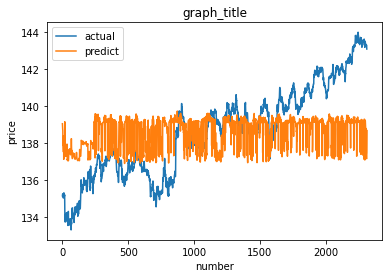

In [6]:
epochs = 40
graph_title = '1h'
y_pred_1h, y_pred = learn(df, X_train, 'y_rate_1h', 'graph_title', epochs, './model/GBPJPY_1h/model.hdf5','./model/GBPJPY_1h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 6s 2ms/step - loss: 0.0576 - mae: 0.1978 - val_loss: 0.1422 - val_mae: 0.3766

Epoch 00001: val_mae improved from inf to 0.37656, saving model to ./model/GBPJPY_2h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0502 - mae: 0.1877 - val_loss: 0.2326 - val_mae: 0.4811

Epoch 00002: val_mae did not improve from 0.37656
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0507 - mae: 0.1859 - val_loss: 0.1333 - val_mae: 0.3635

Epoch 00003: val_mae improved from 0.37656 to 0.36350, saving model to ./model/GB

<Figure size 432x288 with 0 Axes>

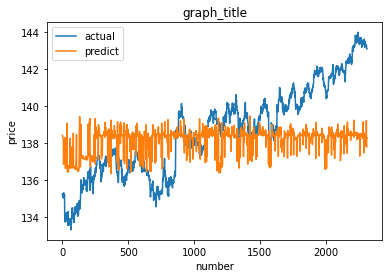

In [7]:

graph_title = '2h'
y_pred_2h, y_pred = learn(df, X_train, 'y_rate_2h', 'graph_title', epochs, './model/GBPJPY_2h/model.hdf5','./model/GBPJPY_2h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 6s 2ms/step - loss: 0.0562 - mae: 0.1972 - val_loss: 0.2642 - val_mae: 0.5136

Epoch 00001: val_mae improved from inf to 0.51361, saving model to ./model/GBPJPY_3h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0519 - mae: 0.1923 - val_loss: 0.9038 - val_mae: 0.9505

Epoch 00002: val_mae did not improve from 0.51361
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.2787 - mae: 0.4826 - val_loss: 0.9038 - val_mae: 0.9505

Epoch 00003: val_mae did not improve from 0.51361
Epoch 4/40
2244/2244 [=========

<Figure size 432x288 with 0 Axes>

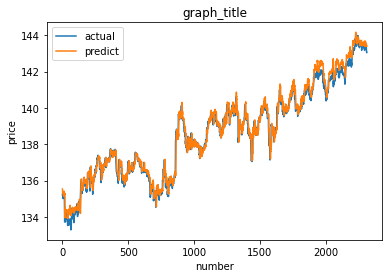

In [8]:

graph_title = '3h'
y_pred_3h, y_pred = learn(df, X_train, 'y_rate_3h', 'graph_title', epochs, './model/GBPJPY_3h/model.hdf5','./model/GBPJPY_3h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 5s 2ms/step - loss: 0.0549 - mae: 0.1942 - val_loss: 0.2358 - val_mae: 0.4852

Epoch 00001: val_mae improved from inf to 0.48518, saving model to ./model/GBPJPY_4h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0514 - mae: 0.1905 - val_loss: 0.0666 - val_mae: 0.2447

Epoch 00002: val_mae improved from 0.48518 to 0.24471, saving model to ./model/GBPJPY_4h\param.hdf5
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0350 - mae: 0.1386 - val_loss: 0.0018 - val_mae: 0.0383

Epoch 00003: val_mae improved f

<Figure size 432x288 with 0 Axes>

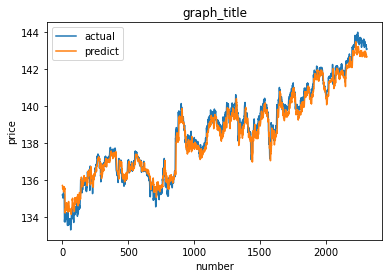

In [9]:

graph_title = '4h'
y_pred_4h, y_pred = learn(df, X_train, 'y_rate_4h', 'graph_title', epochs, './model/GBPJPY_4h/model.hdf5','./model/GBPJPY_4h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 5s 2ms/step - loss: 0.0617 - mae: 0.2058 - val_loss: 0.1626 - val_mae: 0.4027

Epoch 00001: val_mae improved from inf to 0.40272, saving model to ./model/GBPJPY_5h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0524 - mae: 0.1892 - val_loss: 0.8991 - val_mae: 0.9480

Epoch 00002: val_mae did not improve from 0.40272
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.2831 - mae: 0.4848 - val_loss: 0.8991 - val_mae: 0.9480

Epoch 00003: val_mae did not improve from 0.40272
Epoch 4/40
2244/2244 [=========

<Figure size 432x288 with 0 Axes>

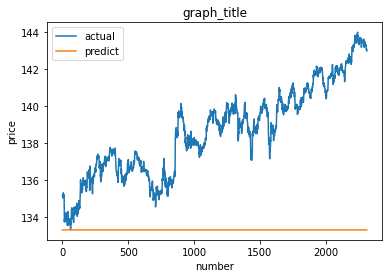

In [10]:

graph_title = '5h'
y_pred_5h, y_pred = learn(df, X_train, 'y_rate_5h', 'graph_title', epochs, './model/GBPJPY_5h/model.hdf5','./model/GBPJPY_5h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 6s 2ms/step - loss: 0.0552 - mae: 0.1941 - val_loss: 0.3018 - val_mae: 0.5489

Epoch 00001: val_mae improved from inf to 0.54890, saving model to ./model/GBPJPY_6h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0950 - mae: 0.2120 - val_loss: 0.2062 - val_mae: 0.4492

Epoch 00002: val_mae improved from 0.54890 to 0.44921, saving model to ./model/GBPJPY_6h\param.hdf5
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0645 - mae: 0.2067 - val_loss: 0.2009 - val_mae: 0.4477

Epoch 00003: val_mae improved f

<Figure size 432x288 with 0 Axes>

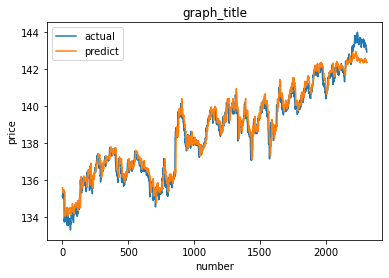

In [11]:

graph_title = '6h'
y_pred_6h, y_pred = learn(df, X_train, 'y_rate_6h', 'graph_title', epochs, './model/GBPJPY_6h/model.hdf5','./model/GBPJPY_6h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 5s 2ms/step - loss: 0.0540 - mae: 0.1920 - val_loss: 0.2032 - val_mae: 0.4502

Epoch 00001: val_mae improved from inf to 0.45023, saving model to ./model/GBPJPY_7h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0513 - mae: 0.1902 - val_loss: 0.2266 - val_mae: 0.4755

Epoch 00002: val_mae did not improve from 0.45023
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0454 - mae: 0.1768 - val_loss: 0.2230 - val_mae: 0.4712

Epoch 00003: val_mae did not improve from 0.45023
Epoch 4/40
2244/2244 [=========

<Figure size 432x288 with 0 Axes>

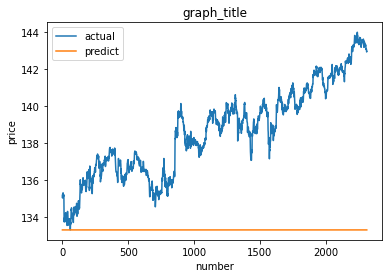

In [12]:

graph_title = '7h'
y_pred_7h, y_pred = learn(df, X_train, 'y_rate_7h', 'graph_title', epochs, './model/GBPJPY_7h/model.hdf5','./model/GBPJPY_7h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 5s 2ms/step - loss: 0.0614 - mae: 0.1996 - val_loss: 0.1439 - val_mae: 0.3341

Epoch 00001: val_mae improved from inf to 0.33406, saving model to ./model/GBPJPY_8h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0546 - mae: 0.1897 - val_loss: 0.2875 - val_mae: 0.5357

Epoch 00002: val_mae did not improve from 0.33406
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0525 - mae: 0.1904 - val_loss: 0.1979 - val_mae: 0.4442

Epoch 00003: val_mae did not improve from 0.33406
Epoch 4/40
2244/2244 [=========

<Figure size 432x288 with 0 Axes>

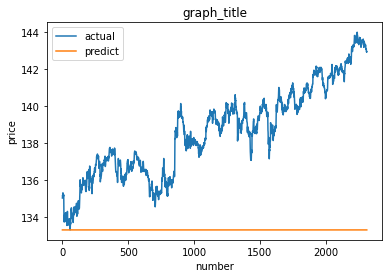

In [13]:

graph_title = '8h'
y_pred_8h, y_pred = learn(df, X_train, 'y_rate_8h', 'graph_title', epochs, './model/GBPJPY_8h/model.hdf5','./model/GBPJPY_8h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 6s 2ms/step - loss: 0.0655 - mae: 0.2082 - val_loss: 0.2146 - val_mae: 0.4629

Epoch 00001: val_mae improved from inf to 0.46288, saving model to ./model/GBPJPY_9h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0510 - mae: 0.1880 - val_loss: 0.2060 - val_mae: 0.4533

Epoch 00002: val_mae improved from 0.46288 to 0.45325, saving model to ./model/GBPJPY_9h\param.hdf5
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0502 - mae: 0.1868 - val_loss: 0.2308 - val_mae: 0.4775

Epoch 00003: val_mae did not im

<Figure size 432x288 with 0 Axes>

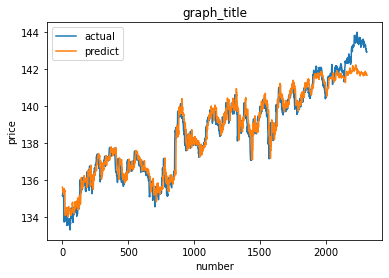

In [14]:

graph_title = '9h'
y_pred_9h, y_pred = learn(df, X_train, 'y_rate_9h', 'graph_title', epochs, './model/GBPJPY_9h/model.hdf5','./model/GBPJPY_9h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 5s 2ms/step - loss: 0.0730 - mae: 0.2125 - val_loss: 0.2889 - val_mae: 0.5372

Epoch 00001: val_mae improved from inf to 0.53717, saving model to ./model/GBPJPY_10h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0500 - mae: 0.1868 - val_loss: 0.1646 - val_mae: 0.4049

Epoch 00002: val_mae improved from 0.53717 to 0.40490, saving model to ./model/GBPJPY_10h\param.hdf5
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0683 - mae: 0.2103 - val_loss: 0.8915 - val_mae: 0.9440

Epoch 00003: val_mae did not 

<Figure size 432x288 with 0 Axes>

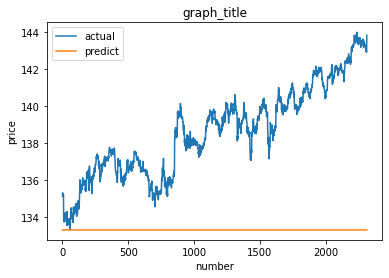

In [15]:

graph_title = '10h'
y_pred_10h, y_pred = learn(df, X_train, 'y_rate_10h', 'graph_title', epochs, './model/GBPJPY_10h/model.hdf5','./model/GBPJPY_10h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 5s 2ms/step - loss: 0.0354 - mae: 0.1449 - val_loss: 0.0350 - val_mae: 0.1837

Epoch 00001: val_mae improved from inf to 0.18372, saving model to ./model/GBPJPY_11h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0192 - mae: 0.1078 - val_loss: 0.0759 - val_mae: 0.2708

Epoch 00002: val_mae did not improve from 0.18372
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0161 - mae: 0.1008 - val_loss: 0.0261 - val_mae: 0.1551

Epoch 00003: val_mae improved from 0.18372 to 0.15510, saving model to ./model/G

c:\users\hnmwt\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\callbacks.py:1765: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
c:\users\hnmwt\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\callbacks.py:1386: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


<Figure size 432x288 with 0 Axes>

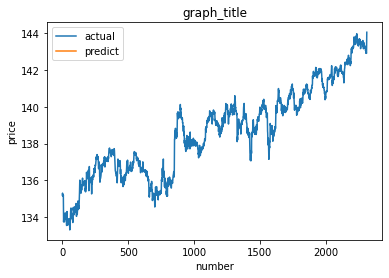

In [16]:

graph_title = '11h'
y_pred_11h, y_pred = learn(df, X_train, 'y_rate_11h', 'graph_title', epochs, './model/GBPJPY_11h/model.hdf5','./model/GBPJPY_11h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 5s 2ms/step - loss: 0.0584 - mae: 0.1994 - val_loss: 0.1698 - val_mae: 0.4113

Epoch 00001: val_mae improved from inf to 0.41129, saving model to ./model/GBPJPY_12h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0504 - mae: 0.1893 - val_loss: 0.1867 - val_mae: 0.4315

Epoch 00002: val_mae did not improve from 0.41129
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0475 - mae: 0.1829 - val_loss: 0.1961 - val_mae: 0.4423

Epoch 00003: val_mae did not improve from 0.41129
Epoch 4/40
2244/2244 [========

<Figure size 432x288 with 0 Axes>

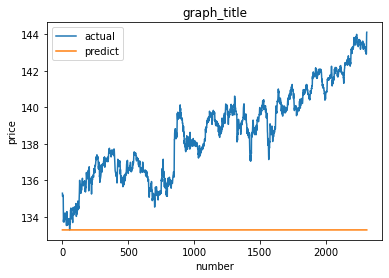

In [17]:

graph_title = '12h'
y_pred_12h, y_pred = learn(df, X_train, 'y_rate_12h', 'graph_title', epochs, './model/GBPJPY_12h/model.hdf5','./model/GBPJPY_12h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 6s 2ms/step - loss: 0.0624 - mae: 0.1885 - val_loss: 0.0578 - val_mae: 0.2369

Epoch 00001: val_mae improved from inf to 0.23694, saving model to ./model/GBPJPY_13h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0171 - mae: 0.1031 - val_loss: 0.0189 - val_mae: 0.1271

Epoch 00002: val_mae improved from 0.23694 to 0.12714, saving model to ./model/GBPJPY_13h\param.hdf5
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0186 - mae: 0.1058 - val_loss: 0.0502 - val_mae: 0.2196

Epoch 00003: val_mae did not 

<Figure size 432x288 with 0 Axes>

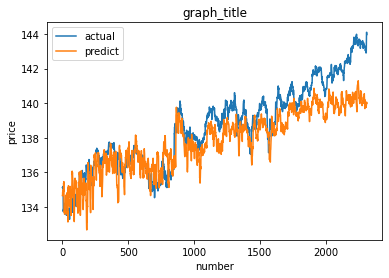

In [18]:

graph_title = '13h'
y_pred_13h, y_pred = learn(df, X_train, 'y_rate_13h', 'graph_title', epochs, './model/GBPJPY_13h/model.hdf5','./model/GBPJPY_13h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 6s 2ms/step - loss: 0.0578 - mae: 0.1992 - val_loss: 0.1911 - val_mae: 0.4366

Epoch 00001: val_mae improved from inf to 0.43661, saving model to ./model/GBPJPY_14h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0504 - mae: 0.1895 - val_loss: 0.2359 - val_mae: 0.4852

Epoch 00002: val_mae did not improve from 0.43661
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0504 - mae: 0.1894 - val_loss: 0.2609 - val_mae: 0.5103

Epoch 00003: val_mae did not improve from 0.43661
Epoch 4/40
2244/2244 [========

<Figure size 432x288 with 0 Axes>

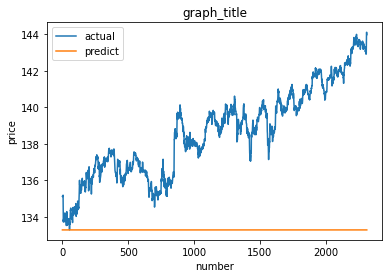

In [19]:

graph_title = '14h'
y_pred_14h, y_pred = learn(df, X_train, 'y_rate_13h', 'graph_title', epochs, './model/GBPJPY_14h/model.hdf5','./model/GBPJPY_14h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 6s 2ms/step - loss: 0.0605 - mae: 0.2019 - val_loss: 0.2713 - val_mae: 0.5203

Epoch 00001: val_mae improved from inf to 0.52029, saving model to ./model/GBPJPY_15h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0511 - mae: 0.1885 - val_loss: 0.8796 - val_mae: 0.9375

Epoch 00002: val_mae did not improve from 0.52029
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.2821 - mae: 0.4823 - val_loss: 0.8796 - val_mae: 0.9375

Epoch 00003: val_mae did not improve from 0.52029
Epoch 4/40
2244/2244 [========

<Figure size 432x288 with 0 Axes>

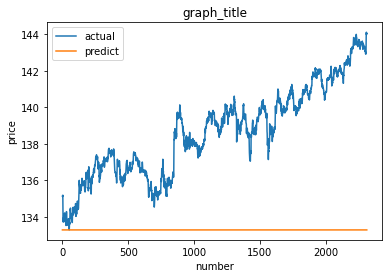

In [20]:

graph_title = '15h'
y_pred_15h, y_pred = learn(df, X_train, 'y_rate_15h', 'graph_title', epochs, './model/GBPJPY_15h/model.hdf5','./model/GBPJPY_15h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 5s 2ms/step - loss: 0.2130 - mae: 0.3634 - val_loss: 0.2192 - val_mae: 0.4673

Epoch 00001: val_mae improved from inf to 0.46733, saving model to ./model/GBPJPY_16h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0490 - mae: 0.1826 - val_loss: 0.3128 - val_mae: 0.5586

Epoch 00002: val_mae did not improve from 0.46733
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0489 - mae: 0.1851 - val_loss: 0.2630 - val_mae: 0.5120

Epoch 00003: val_mae did not improve from 0.46733
Epoch 4/40
2244/2244 [========

<Figure size 432x288 with 0 Axes>

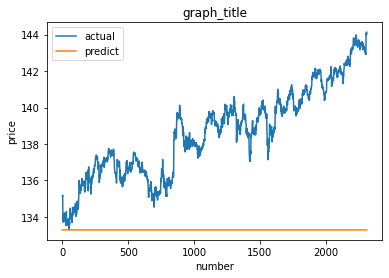

In [21]:

graph_title = '16h'
y_pred_16h, y_pred = learn(df, X_train, 'y_rate_16h', 'graph_title', epochs, './model/GBPJPY_16h/model.hdf5','./model/GBPJPY_16h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 6s 2ms/step - loss: 0.0533 - mae: 0.1897 - val_loss: 0.2176 - val_mae: 0.4658

Epoch 00001: val_mae improved from inf to 0.46576, saving model to ./model/GBPJPY_17h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0504 - mae: 0.1887 - val_loss: 0.0856 - val_mae: 0.2790

Epoch 00002: val_mae improved from 0.46576 to 0.27897, saving model to ./model/GBPJPY_17h\param.hdf5
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.2029 - mae: 0.3861 - val_loss: 0.8530 - val_mae: 0.9232

Epoch 00003: val_mae did not 

<Figure size 432x288 with 0 Axes>

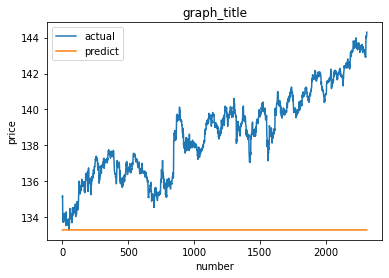

In [22]:

graph_title = '17h'
y_pred_17h, y_pred = learn(df, X_train, 'y_rate_17h', 'graph_title', epochs, './model/GBPJPY_17h/model.hdf5','./model/GBPJPY_17h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 5s 2ms/step - loss: 0.0550 - mae: 0.1911 - val_loss: 0.2084 - val_mae: 0.4556

Epoch 00001: val_mae improved from inf to 0.45558, saving model to ./model/GBPJPY_18h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0613 - mae: 0.2003 - val_loss: 0.8474 - val_mae: 0.9201

Epoch 00002: val_mae did not improve from 0.45558
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.2736 - mae: 0.4765 - val_loss: 0.8474 - val_mae: 0.9201

Epoch 00003: val_mae did not improve from 0.45558
Epoch 4/40
2244/2244 [========

<Figure size 432x288 with 0 Axes>

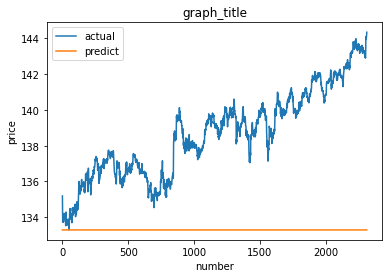

In [23]:

graph_title = '18h'
y_pred_18h, y_pred = learn(df, X_train, 'y_rate_18h', 'graph_title', epochs, './model/GBPJPY_18h/model.hdf5','./model/GBPJPY_18h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 5s 2ms/step - loss: 0.0572 - mae: 0.1984 - val_loss: 0.1562 - val_mae: 0.3941

Epoch 00001: val_mae improved from inf to 0.39409, saving model to ./model/GBPJPY_19h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0453 - mae: 0.1769 - val_loss: 0.3221 - val_mae: 0.5667

Epoch 00002: val_mae did not improve from 0.39409
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.1910 - mae: 0.3732 - val_loss: 0.8493 - val_mae: 0.9211

Epoch 00003: val_mae did not improve from 0.39409
Epoch 4/40
2244/2244 [========

<Figure size 432x288 with 0 Axes>

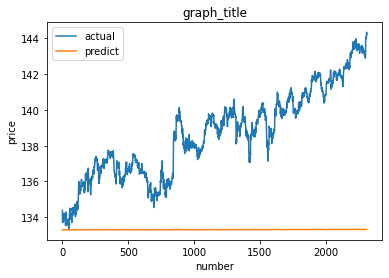

In [24]:

graph_title = '19h'
y_pred_19h, y_pred = learn(df, X_train, 'y_rate_19h', 'graph_title', epochs, './model/GBPJPY_19h/model.hdf5','./model/GBPJPY_19h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 5s 2ms/step - loss: 1.6115 - mae: 0.5453 - val_loss: 0.2306 - val_mae: 0.4793

Epoch 00001: val_mae improved from inf to 0.47930, saving model to ./model/GBPJPY_20h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0478 - mae: 0.1853 - val_loss: 0.1586 - val_mae: 0.3971

Epoch 00002: val_mae improved from 0.47930 to 0.39714, saving model to ./model/GBPJPY_20h\param.hdf5
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0427 - mae: 0.1699 - val_loss: 0.0285 - val_mae: 0.1567

Epoch 00003: val_mae improved

<Figure size 432x288 with 0 Axes>

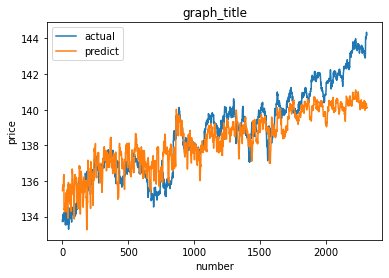

In [25]:

graph_title = '20h'
y_pred_20h, y_pred = learn(df, X_train, 'y_rate_20h', 'graph_title', epochs, './model/GBPJPY_20h/model.hdf5','./model/GBPJPY_20h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 5s 2ms/step - loss: 0.1017 - mae: 0.2262 - val_loss: 0.1842 - val_mae: 0.4274

Epoch 00001: val_mae improved from inf to 0.42737, saving model to ./model/GBPJPY_21h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0515 - mae: 0.1889 - val_loss: 0.1935 - val_mae: 0.4385

Epoch 00002: val_mae did not improve from 0.42737
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0501 - mae: 0.1853 - val_loss: 0.1747 - val_mae: 0.4167

Epoch 00003: val_mae improved from 0.42737 to 0.41671, saving model to ./model/G

<Figure size 432x288 with 0 Axes>

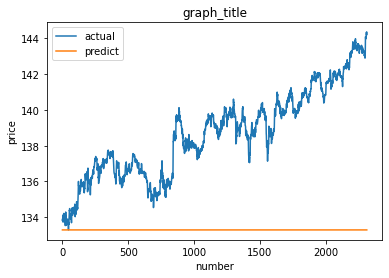

In [26]:

graph_title = '21h'
y_pred_21h, y_pred = learn(df, X_train, 'y_rate_21h', 'graph_title', epochs, './model/GBPJPY_21h/model.hdf5','./model/GBPJPY_21h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 5s 2ms/step - loss: 0.0510 - mae: 0.1869 - val_loss: 0.2244 - val_mae: 0.4725

Epoch 00001: val_mae improved from inf to 0.47253, saving model to ./model/GBPJPY_22h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0456 - mae: 0.1784 - val_loss: 0.1625 - val_mae: 0.4017

Epoch 00002: val_mae improved from 0.47253 to 0.40173, saving model to ./model/GBPJPY_22h\param.hdf5
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0469 - mae: 0.1787 - val_loss: 0.1022 - val_mae: 0.3069

Epoch 00003: val_mae improved

<Figure size 432x288 with 0 Axes>

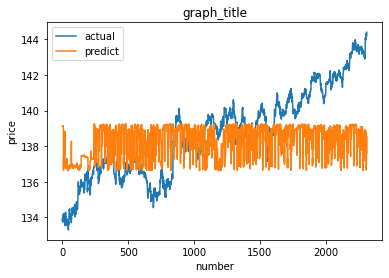

In [27]:

graph_title = '22h'
y_pred_22h, y_pred = learn(df, X_train, 'y_rate_22h', 'graph_title', epochs, './model/GBPJPY_22h/model.hdf5','./model/GBPJPY_22h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 5s 2ms/step - loss: 0.0551 - mae: 0.1938 - val_loss: 0.2329 - val_mae: 0.4813

Epoch 00001: val_mae improved from inf to 0.48132, saving model to ./model/GBPJPY_23h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0469 - mae: 0.1813 - val_loss: 0.1545 - val_mae: 0.3916

Epoch 00002: val_mae improved from 0.48132 to 0.39157, saving model to ./model/GBPJPY_23h\param.hdf5
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0958 - mae: 0.2473 - val_loss: 0.8483 - val_mae: 0.9204

Epoch 00003: val_mae did not 

<Figure size 432x288 with 0 Axes>

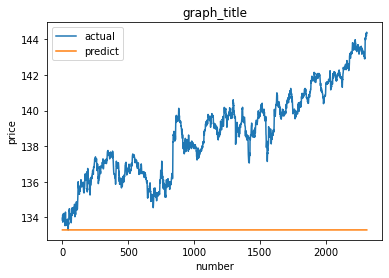

In [28]:

graph_title = '23h'
y_pred_23h, y_pred = learn(df, X_train, 'y_rate_23h', 'graph_title', epochs, './model/GBPJPY_23h/model.hdf5','./model/GBPJPY_23h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 2314
列数: 18
整形前の形状(特徴量): (2314, 18)
形状(特徴量): (2314, 18, 1)
形状(目的変数): (2314, 1)
モデルの学習を開始します
Epoch 1/40
2244/2244 [==============================] - 5s 2ms/step - loss: 0.0522 - mae: 0.1882 - val_loss: 0.2559 - val_mae: 0.5047

Epoch 00001: val_mae improved from inf to 0.50471, saving model to ./model/GBPJPY_24h\param.hdf5
Epoch 2/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0477 - mae: 0.1832 - val_loss: 0.0758 - val_mae: 0.2713

Epoch 00002: val_mae improved from 0.50471 to 0.27125, saving model to ./model/GBPJPY_24h\param.hdf5
Epoch 3/40
2244/2244 [==============================] - 4s 2ms/step - loss: 0.0784 - mae: 0.1896 - val_loss: 0.2214 - val_mae: 0.4679

Epoch 00003: val_mae did not 

<Figure size 432x288 with 0 Axes>

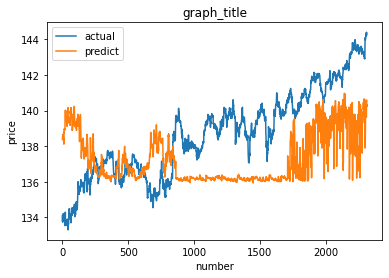

In [29]:

graph_title = '24h'
y_pred_24h, y_pred = learn(df, X_train, 'y_rate_24h', 'graph_title', epochs, './model/GBPJPY_24h/model.hdf5','./model/GBPJPY_24h/param.hdf5') # 学習関数


[[138.69487223]
 [138.28597762]
 [143.40643192]
 [142.65883608]
 [133.288     ]
 [142.38098452]
 [133.288     ]
 [133.288     ]
 [141.68625294]
 [133.288     ]
 [         nan]
 [133.288     ]
 [140.06220458]
 [133.288     ]
 [133.288     ]
 [133.28799994]
 [133.288     ]
 [133.288     ]
 [133.31165406]
 [140.15258516]
 [133.288     ]
 [138.54704625]
 [133.288     ]
 [140.20697481]]


<Figure size 432x288 with 0 Axes>

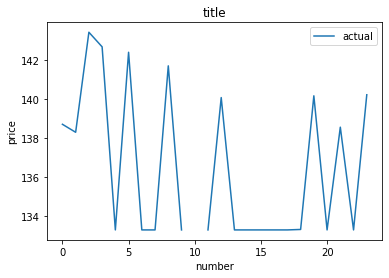

In [30]:
plot_list = np.concatenate([y_pred_1h, y_pred_2h, y_pred_3h, y_pred_4h, y_pred_5h, y_pred_6h, y_pred_7h, y_pred_8h
                           , y_pred_9h, y_pred_10h, y_pred_11h, y_pred_12h, y_pred_13h, y_pred_14h, y_pred_15h, y_pred_16h
                           , y_pred_17h, y_pred_18h, y_pred_19h, y_pred_20h, y_pred_21h, y_pred_22h, y_pred_23h, y_pred_24h])# 5m, 1h, 4h, 8h, 1dの予測リスト

def plot_pred(plot_list):
    flg = plt.figure()
    fig = plt.figure(figsize=(6, 4), dpi=72, linewidth=10)
    ax = fig.add_subplot(111, xlabel='number', ylabel='price',title='title')  # グラフ作成
    
    ax.plot(plot_list, label='actual')  # 5m, 1h, 4h, 8h, 1dの予測リスト
   # ax.plot(y_pred, label='predict')  # 予測
    plt.legend()

plot_pred(plot_list)
print(plot_list)

In [31]:
a = df['y_rate_2h'].tolist() # Tolistを使う予定

y = a - y_pred


In [32]:
print(len(a))
print(len(y_pred))
print(len(y))


2314
2314
2314


In [33]:
#tensorboard --logdir='./logs'